<a href="https://colab.research.google.com/github/celiaferreira/Covid19_RX/blob/master/8_1_TransferLearning_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 8.1. Transfer learning

In this section we evaluate the predictive power of pre-trained networks: **InceptionResNetV2** and **ResNet50**.

•	The convolutional layers closest to the model's input layer learn low-level features, such as lines.

•	Intermediate layers learn abstract and complex features that combine lower-level features extracted from the input.

•	The layers closest to the output interpret the extracted features in the context of a classification task.

Thus, when using weights from pre-trained networks, it may be convenient to allow them to be updated to better fit the problem.




### 8.1.1. InceptionResNetV2: imagenet weights | Untrainable

The first model uses the InceptionResNetV2 network. We will use the imagenet pre-trained weights and calculate the outputs of pre-trained networks for our training cases. These outputs will be used as inputs in a complementary connected network, which will be trained. will allow the feature extraction part to be retrained.

Since X-ray images are very different from *imagenet* images, we anticipate that training the weights of the convolutional layers will be necessary.


In [ ]:
from keras.applications import InceptionResNetV2, ResNet50
InceptionResNetV2_model1 = InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(200,200,3))
#Inception-ResNet-v2 combines the advantages of Inception networks and residual connections to achieve state-of-the-art accuracy on the ILSVRC image classification benchmark

219062272/219055592 [==============================] - 5s 0us/step


Since our input images are already pre-processed, they will only be converted to RGB and the predictive power of the **InceptionResNetV2** network will be evaluated, to avoid a new import without any pre-processing.

In [ ]:
#By default, the model expects color input images to be rescaled to the size of 224×224 squares.

X_over3_rgb = X_over3.reshape(len(y_over3),200,200)

print(X_over3_rgb.shape) 
X_over3_rgb = np.repeat(X_over3_rgb[..., np.newaxis], 3, -1)
print(X_over3_rgb.shape)

X_val_rgb = X_val.reshape(len(y_val3),200,200)
X_val_rgb = np.repeat(X_val_rgb[..., np.newaxis], 3, -1)
print(X_val_rgb.shape)

X_test_rgb = X_test.reshape(len(y_test3),200,200)
X_test_rgb = np.repeat(X_test_rgb[..., np.newaxis], 3, -1)
print(X_test_rgb.shape)

We present the model that uses the InceptionResNetV2 network, combined with dropout layers to minimize overfitting. It is also identified that the weights of the convolutional layers should not be trained.

In [ ]:
headModel = InceptionResNetV2_model1.output
headModel = Dropout(0.5)(headModel)
headModel = Flatten()(headModel)

headModel=Dense(64,activation='relu')(headModel) 
headModel = Dropout(0.5)(headModel)
headModel=Dense(16,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel) 
headModel=Dense(3,activation='softmax')(headModel)
model11 = Model(inputs=InceptionResNetV2_model1.input, outputs=headModel)

for layer in InceptionResNetV2_model1.layers:
    layer.trainable = False

model11.compile(optimizers.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['acc'])

In [ ]:
history11=model11.fit(X_over3_rgb, y_over3, epochs=20, validation_data=(X_val_rgb,y_val3), callbacks = callbacks, verbose=0)

Predicted    0    1    2
Actual                  
0          193  132    5
1            1  754  148
2            0  115  759
accuracy total: 0.8096820123398196
precision covid: 0.9948453608247423
recall covid: 0.5848484848484848
precision total: 0.8601096520589196
recall total: 0.7627546667938345
label precision recall
    0     0.995  0.585
    1     0.753  0.835
    2     0.832  0.868
2107/2107 [==============================] - 10s 5ms/step
[0.5115011525369109, 0.8096820116043091]


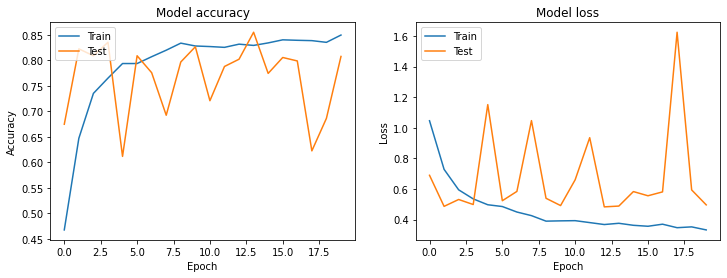

In [ ]:
output_metrics_b(model11,history11,X_test_rgb, y_test3)

The model achieves an overall performance of 81%, lower than previous models. However, the biggest problem is the COVID recall: only 58.5% of cases are identified, which is very poor, despite training for 18 epochs.

The graphs also present greater instability in the validation set, as well as overfitting, despite the dropout layers used.

As expected, the weights/features learned in imagenet are not being very useful for identifying COVID in X-ray images.

### 8.1.2. InceptionResNetV2: imagenet weights | Trainable

Although using *imagenet* weights, in this section we will allow the last layers (which learn more specific aspects of the problems under analysis) to be retrained.

Let's identify the name of the network layers:

In [ ]:
#InceptionResNetV2_model1.summary()

We will allow the training of the layers **block8_10_conv**, **conv_7b** and **conv_7b_bn** (other networks were also trained, but the results did not improve):

In [ ]:
InceptionResNetV2_model1.trainable = True
#treinar últimos layers
set_trainable = False
for layer in InceptionResNetV2_model1.layers:
    if layer.name in ( 'block8_10_conv', 'conv_7b','conv_7b_bn'):
      #'block8_9_conv', 'conv2d_201', 'conv2d_202', 'conv2d_200', 'conv2d_203',
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
                
headModel = InceptionResNetV2_model1.output
headModel = Dropout(0.5)(headModel)
headModel = Flatten()(headModel)
headModel=Dense(64,activation='relu')(headModel) 
headModel = Dropout(0.5)(headModel)
headModel=Dense(16,activation='relu')(headModel) 
headModel = Dropout(0.5)(headModel)
headModel=Dense(3,activation='softmax')(headModel)
model11b = Model(inputs=InceptionResNetV2_model1.input, outputs=headModel)

model11b.compile(optimizers.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['acc'])

In [ ]:
history11b=model11b.fit(X_over3_rgb, y_over3, epochs=20,validation_data=(X_val_rgb,y_val3), callbacks = callbacks,verbose=0)

Epoch 00019: early stopping


Predicted    0    1    2
Actual                  
0          280   30   20
1          199  313  391
2           65  151  658
accuracy total: 0.593735168485999
precision covid: 0.5147058823529411
recall covid: 0.8484848484848485
precision total: 0.587945884185679
recall total: 0.6493225434207819
label precision recall
    0     0.515  0.848
    1     0.634  0.347
    2     0.616  0.753
2107/2107 [==============================] - 10s 5ms/step
[4.539995085304814, 0.5937351584434509]


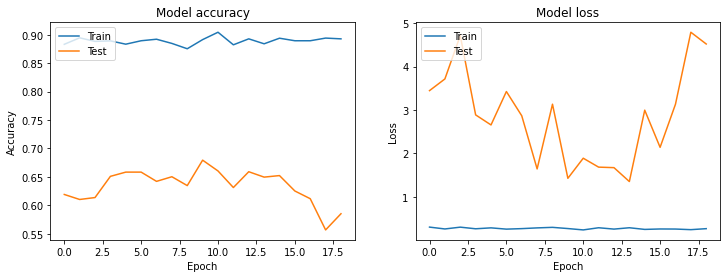

In [ ]:
output_metrics_b(model11b,history11b,X_test_rgb, y_test3)

After 19 epochs, the model achieves an even lower overall performance: 59.4%, but identifying 84.4% COVID cases: the model makes fewer mistakes in COVID, but more in general. It also reveals a high overfitting. Conclusion- If so, the direct use of *imagenet* weights does not present good results in our problem.

### 8.1.3. InceptionResNetV2: use topology | Trainable weights

In this section we will use the **InceptionResNetV2** pre-trained model architecture on our dataset, but without using the pre-trained weights: the model will be initialized with random weights and trained from scratch. To do this, we configure the argument **weights=None**, instead of weights='Imagenet'.

In [ ]:
#Inception-ResNet-v2 combines the advantages of Inception networks and residual connections to achieve state-of-the-art accuracy on the ILSVRC image classification benchmark

In this approach we will only use the InceptionResNetV2 network architecture on our dataset, but without using the pre-trained weights, which will be randomly initialized and re-trained from scratch.

In [ ]:
InceptionResNetV2_model = InceptionResNetV2(weights=None, include_top=False,	input_tensor=Input(shape=(200, 200, 1)))

To the model we combined dropout layers to control overfitting and the usual fully-connected layer.

In [ ]:
headModel = InceptionResNetV2_model.output
headModel = Dropout(0.5)(headModel)
headModel = Flatten()(headModel)
headModel=Dense(64,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(16,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(3,activation='softmax')(headModel)
model11c = Model(inputs=InceptionResNetV2_model.input, outputs=headModel)

We give instructions to train the weights and start the training:

In [ ]:
InceptionResNetV2_model.trainable = True

model11c.compile(optimizers.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history11c=model11c.fit(X_over3, y_over3, epochs=50,validation_data=(X_val,y_val3),callbacks = callbacks, verbose=0)

Epoch 00020: early stopping


Predicted    0    1    2
Actual                  
0          325    6    7
1           19  803   80
2            6   15  846
accuracy total: 0.9368770764119602
precision covid: 0.9285714285714286
recall covid: 0.9615384615384616
precision total: 0.9366128010845959
recall total: 0.9425203035634295
label precision recall
    0     0.929  0.962
    1     0.975  0.890
    2     0.907  0.976
2107/2107 [==============================] - 9s 4ms/step
[0.2698990872362297, 0.9368770718574524]


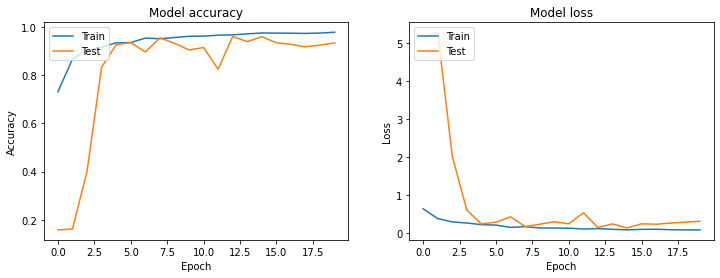

In [ ]:
output_metrics(model11c,history11c,X_test, y_test3)

This model gives interesting results:

* overall performance of 93.7%
* COVID recall: 96.2%
* absence of overfitting

This is because the weights were trained from the feature extractor layer for our problem.

### 8.1.4. ResNet50: Frozen layers

Nesta secção usamos mais um modelo de TL: o ResNet50, para comparar a performance com a rede anterior.

Começamos por importar os pesos da rede Resnet50:

In [ ]:
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

from keras.utils.data_utils import get_file
weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')


94658560/94653016 [==============================] - 2s 0us/step


Transformar imagens em RGB (3 canais), para usar weights de redes pré-treinadas.

In [ ]:
print(X_train.shape)
X_train2 = X_train.reshape(len(y_train3),200,200)
X_train2 = np.repeat(X_train2[..., np.newaxis], 3, -1)
print(X_train2.shape)  

print(X_val.shape)
X_val2 = X_val.reshape(len(y_val3),200,200)
X_val2 = np.repeat(X_val2[..., np.newaxis], 3, -1)
print(X_val2.shape)  


print(X_test.shape)
X_test2 = X_test.reshape(len(y_test3),200,200)
X_test2 = np.repeat(X_test2[..., np.newaxis], 3, -1)
print(X_test2.shape) 

print(X_over3.shape)
X_over2 = X_over3.reshape(len(y_over3),200,200)
X_over2 = np.repeat(X_over2[..., np.newaxis], 3, -1)
print(X_over2.shape)  

(3441, 200, 200, 1)
(3441, 200, 200, 3)
(1475, 200, 200, 1)
(1475, 200, 200, 3)
(2107, 200, 200, 1)
(2107, 200, 200, 3)
(4494, 200, 200, 1)
(4494, 200, 200, 3)


Iremos usar os pesos importados da camada concolucional, excluíndo a camada fully-connected, de classificação, da rede resnet50.

In [ ]:
ResNet50_model = ResNet50(weights=weights_path, include_top=False,	input_tensor=Input(shape=(200, 200, 3)))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Especificamos o modelo conjugando a rede Resnet50 com camadas de dropout e fully-connected:

In [ ]:
headModel = ResNet50_model.output
headModel = Dropout(0.5)(headModel)
headModel = Flatten()(headModel)
headModel=Dense(64,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(16,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(3,activation='softmax')(headModel)
model12 = Model(inputs=ResNet50_model.input, outputs=headModel)

Indicamos que os pesos da camada convolucional não devem ser re-treinados e iniciamos o treino do modelo:

In [ ]:
ResNet50_model.trainable = False

model12.compile(optimizers.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history12=model12.fit(X_over2, y_over3, epochs=50,validation_data=(X_val2,y_val3), verbose=0, callbacks = callbacks)

Epoch 00017: early stopping


Predicted    0    1    2
Actual                  
0          336    0    2
1          176  253  473
2           33    3  831
accuracy total: 0.6739439962031324
precision covid: 0.6165137614678899
recall covid: 0.9940828402366864
precision total: 0.7470296796776581
recall total: 0.744349384588418
label precision recall
    0     0.617  0.994
    1     0.988  0.280
    2     0.636  0.958
2107/2107 [==============================] - 7s 3ms/step
[1.31810581073073, 0.6739439964294434]


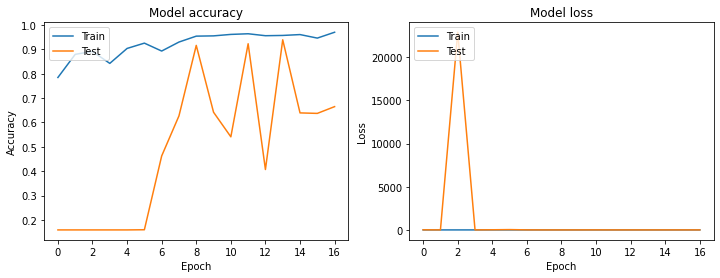

In [ ]:
output_metrics(model12,history12,X_test2, y_test3)

* O modelo apresenta uma performance global de 67,4%, com um recall muito interessante de 99,4% no COVID, embora a precisão COVID seja de apenas 61,7%.

* Adicionalmente, observa-se overfitting.

Assim, este modelo com pesos não treináveis também não apresenta resultados satisfatórios.

### 8.1.5.  ResNet50: Fine-tune Layers

Para a rede ResNet50, vamos permitir o fine-tuning das últimas 6 camadas da rede (res5b_branch2a, res5b_branch2b, res5b_branch2c, res5c_branch2a, res5c_branch2b, res5c_branch2c).

In [ ]:
#print(ResNet50_model.summary())


O descongelamento dos layer iniciais não é aconselhável porque estes são mais genéricos e reutilizáveis, enquanto os layers finais extraem features mais especializadas, mais dependentes dos dados do treino e do problema em análise.
Adicionalmente, o treino de mais parâmetros potencia o risco de overfitting.


**Definição dos layers a re-treinar:**

In [ ]:
ResNet50_model.trainable = True
#treinar 2 últimor layers 'identity', com 3 camadas convolucionais cada
set_trainable = False
for layer in ResNet50_model.layers:
    if layer.name in ('res5b_branch2a', 'res5b_branch2b','res5b_branch2c','res5c_branch2a','res5c_branch2b','res5c_branch2c'):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in ResNet50_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Layer Type  ... Layer Trainable
0    <keras.engine.input_layer.InputLayer object at...  ...           False
1    <keras.layers.convolutional.ZeroPadding2D obje...  ...           False
2    <keras.layers.convolutional.Conv2D object at 0...  ...           False
3    <keras.layers.normalization.BatchNormalization...  ...           False
4    <keras.layers.core.Activation object at 0x7fe8...  ...           False
..                                                 ...  ...             ...
170  <keras.layers.core.Activation object at 0x7fe4...  ...            True
171  <keras.layers.convolutional.Conv2D object at 0...  ...            True
172  <keras.layers.normalization.BatchNormalization...  ...            True
173  <keras.layers.merge.Add object at 0x7fe444a9bc88>  ...            True
174  <keras.layers.core.Activation object at 0x7fe4...  ...            True

[175 rows x 3 columns]

In [ ]:
headModel = ResNet50_model.output
headModel = Dropout(0.5)(headModel)
headModel = Flatten()(headModel)
headModel=Dense(64,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(16,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(3,activation='softmax')(headModel)
model13 = Model(inputs=ResNet50_model.input, outputs=headModel)

model13.compile(optimizers.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history13=model13.fit(X_over2, y_over3, epochs=50,validation_data=(X_val2,y_val3), verbose=0, callbacks = callbacks)

Epoch 00006: early stopping


Predicted    0   1    2
Actual                 
0          336   0    2
1          240  58  604
2           18   0  849
accuracy total: 0.589938300901756
precision covid: 0.5656565656565656
recall covid: 0.9940828402366864
precision total: 0.7163872400985803
recall total: 0.6792077155561254
label precision recall
    0     0.566  0.994
    1     1.000  0.064
    2     0.584  0.979
2107/2107 [==============================] - 7s 3ms/step
[11.52650690735037, 0.5899382829666138]


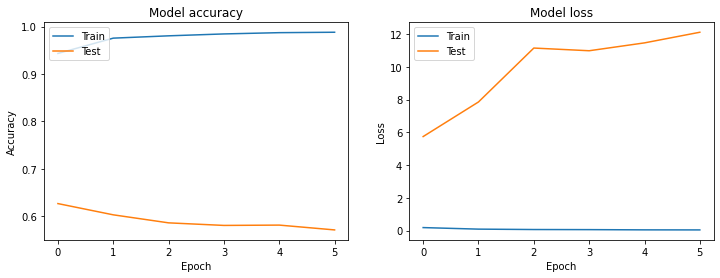

In [ ]:
output_metrics(model13,history13,X_test2, y_test3)

* Nesta situação a performance global é de 59%, com um recall 99% no COVID. O modelo garante o mínimo de falsos negativos COVID, mas apresenta lobalmente erros elevados.

* Observa-se ainda elevado overfitting, apesar das camadas de dropout usadas.


---


Quanto à utilização de transfer learning para prever o COVID foi obtido apenas um modelo interessante:

* usar a arquitetura da rede InnceptionRedNetV2, mas re-treinando os pesos. 

---

